# Bayes-by-backprop

In [1]:
import jax
import optax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState

In [2]:
sns.set_palette("colorblind")

%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [3]:
key = jax.random.PRNGKey(3141)
key_data, key_init, key_train, key_eval = jax.random.split(key, 4)

## Dataset

In [4]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    return out

xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()

### Training dataset

In [5]:
n_obs = 15
x_samples = jax.random.uniform(key_data, shape=(n_obs,1), minval=-4, maxval=4)
y_samples = ackley_1d(x_samples)

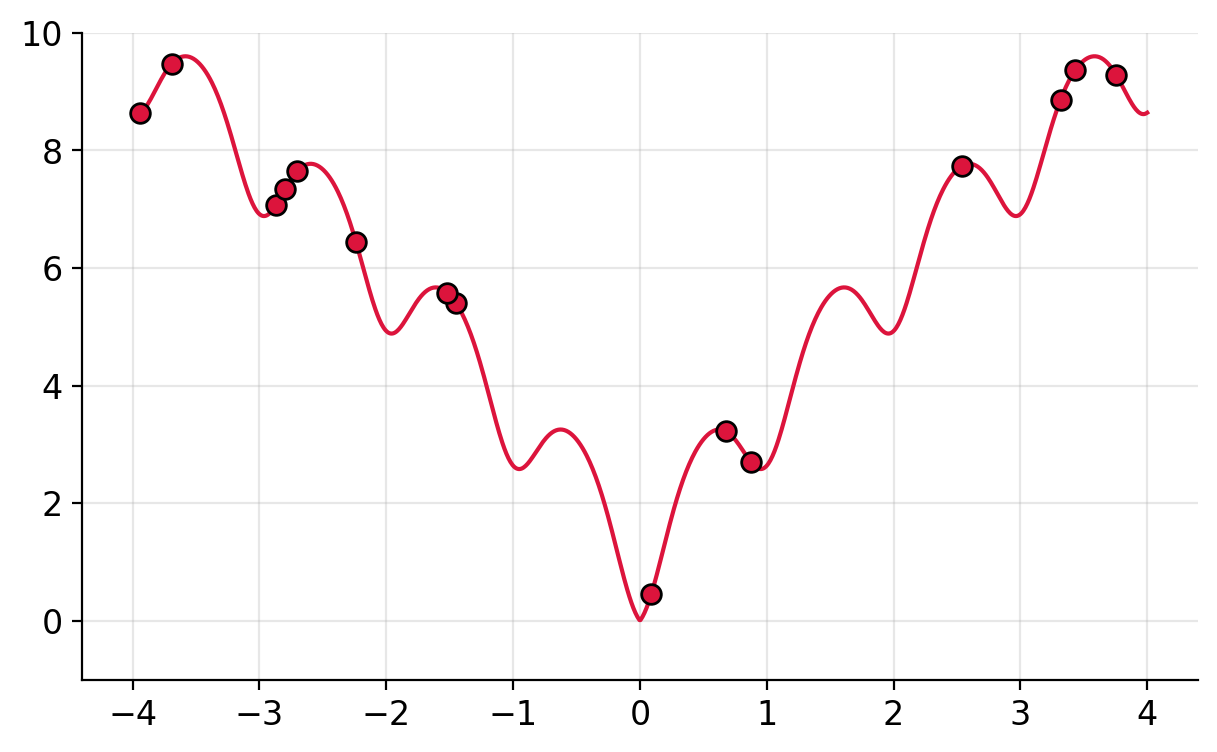

In [6]:
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, edgecolor="black", c="crimson", zorder=3, s=50)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## The neural network

In [7]:
class MLP(nn.Module):
    n_hidden: int = 20 # 180

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

## BBB

In [8]:
model = MLP()
keys_init = jax.random.split(key_init, 2)
pinit = jax.vmap(model.init, in_axes=(0, None))(keys_init, x_samples)

rho = jax.tree.map(lambda x: x[1], pinit)
mu = jax.tree.map(lambda x: x[0], pinit)

In [9]:
params_flat, rfn = ravel_pytree(mu)
n_params = len(params_flat)

### Implementation

In [10]:
def log_likelihood(theta, y, x, scale):
    mean = model.apply(theta, x)
    return jax.scipy.stats.norm.logpdf(y.ravel(), mean.ravel(), scale=scale).sum()


gll = jax.vmap(jax.grad(log_likelihood), in_axes=(0, None, None, None))
gll = jax.vmap(gll, in_axes=(None, 0, 0, None))


def sample_noise_pytree(key, n_samples, n_params, rfn_pytree):
    eps = jax.random.normal(key, (n_samples, n_params))
    eps = jax.vmap(rfn_pytree)(eps)
    return eps


def eval_params(eps, mu, rho):
    sigma = jnp.log(1 + jnp.exp(rho))
    theta = mu + eps * jnp.sqrt(sigma)
    return theta


def grad_rho_flat(eps, grads_ll, rho, alpha):
    sigma = jnp.log(1 + jnp.exp(rho))
    grads = (eps * grads_ll).mean(axis=1).sum(axis=0)
    grads = (1 / alpha - 1 / sigma) - 1 / jnp.sqrt(sigma) * grads
    grads = grads * jax.nn.sigmoid(rho) / 2
    return grads


def grad_rho(mu, rho, key, n_samples, y, x, alpha, obs_std):
    eps = sample_noise_pytree(key, n_samples, n_params, rfn)
    theta = jax.tree.map(eval_params, eps, mu, rho)
    
    grads_ll = gll(theta, y, x, obs_std)
    gfn = partial(grad_rho_flat, alpha=alpha)
    grads = jax.tree.map(gfn, eps, grads_ll, rho)
    
    return grads


def grad_mu_flat(eps, grads_ll, mu, alpha):
    grads = mu / alpha - grads_ll.mean(axis=1).sum(axis=0)
    return grads


def grad_mu(mu, rho, key, n_samples, y, x, alpha, obs_std):
    eps = sample_noise_pytree(key, n_samples, n_params, rfn)
    theta = jax.tree.map(eval_params, eps, mu, rho)
    
    grads_ll = gll(theta, y, x, obs_std)
    gfn = partial(grad_mu_flat, alpha=alpha)
    grads = jax.tree.map(gfn, eps, grads_ll, mu)
    
    return grads

In [11]:
def get_kl_flat(mu, rho, alpha):
    D = len(mu)
    sigma = jnp.log(1 + jnp.exp(rho))
    KL = 0.5 * jnp.sum(sigma / alpha + mu ** 2 / alpha - D + jnp.log(alpha) - jnp.log(sigma))
    return KL


def elbo(key, mu, rho, y, x, alpha, obs_std, n_samples=30):
    eps = sample_noise_pytree(key, n_samples, n_params, rfn)
    thetas_sample = jax.tree.map(eval_params, eps, mu, rho)

    log_likelihoods = jax.vmap(log_likelihood, in_axes=(0, None, None, None))(thetas_sample, y, x, obs_std)
    E_log_likelihood = log_likelihoods.mean()

    mu_flat, _ = ravel_pytree(mu)
    rho_flat, _ = ravel_pytree(rho)
    KL = get_kl_flat(mu_flat, rho_flat, alpha)

    return E_log_likelihood - KL

In [12]:
def step(states, key, y, x, alpha, obs_std):
    """
    Full-batch update step
    """
    key_grad, key_eval = jax.random.split(key)
    state_mu, state_rho = states

    grads_rho = grad_rho(
        state_mu.params, state_rho.params, key_grad, n_samples, y, x, alpha, obs_std
    )
    
    grads_mu = grad_mu(
        state_mu.params, state_rho.params, key_grad, n_samples, y, x, alpha, obs_std
    )

    state_mu = state_mu.apply_gradients(grads=grads_mu)
    state_rho = state_rho.apply_gradients(grads=grads_rho)
    states = (state_mu, state_rho)

    loss = elbo(key, state_mu.params, state_rho.params, y, x, alpha, obs_std)

    return states, -loss

In [13]:
n_samples = 100

state_mu = TrainState.create(
    apply_fn=None,
    params=mu,
    tx=optax.adamw(5e-3)
)

state_rho = TrainState.create(
    apply_fn=None,
    params=rho,
    tx=optax.adamw(5e-3)
)

In [14]:
%%time
alpha = 1.0
states_init = (state_mu, state_rho)
epochs = jax.random.split(key_train, 10_000)
_step = partial(step, alpha=alpha, y=y_samples, x=x_samples, obs_std=1e-3)
(state_mu_final, state_rho_final), hist = jax.lax.scan(_step, states_init, epochs)
hist = jax.block_until_ready(hist)

CPU times: user 2min 28s, sys: 17.5 s, total: 2min 45s
Wall time: 36.3 s


Text(0, 0.5, '-ELBO')

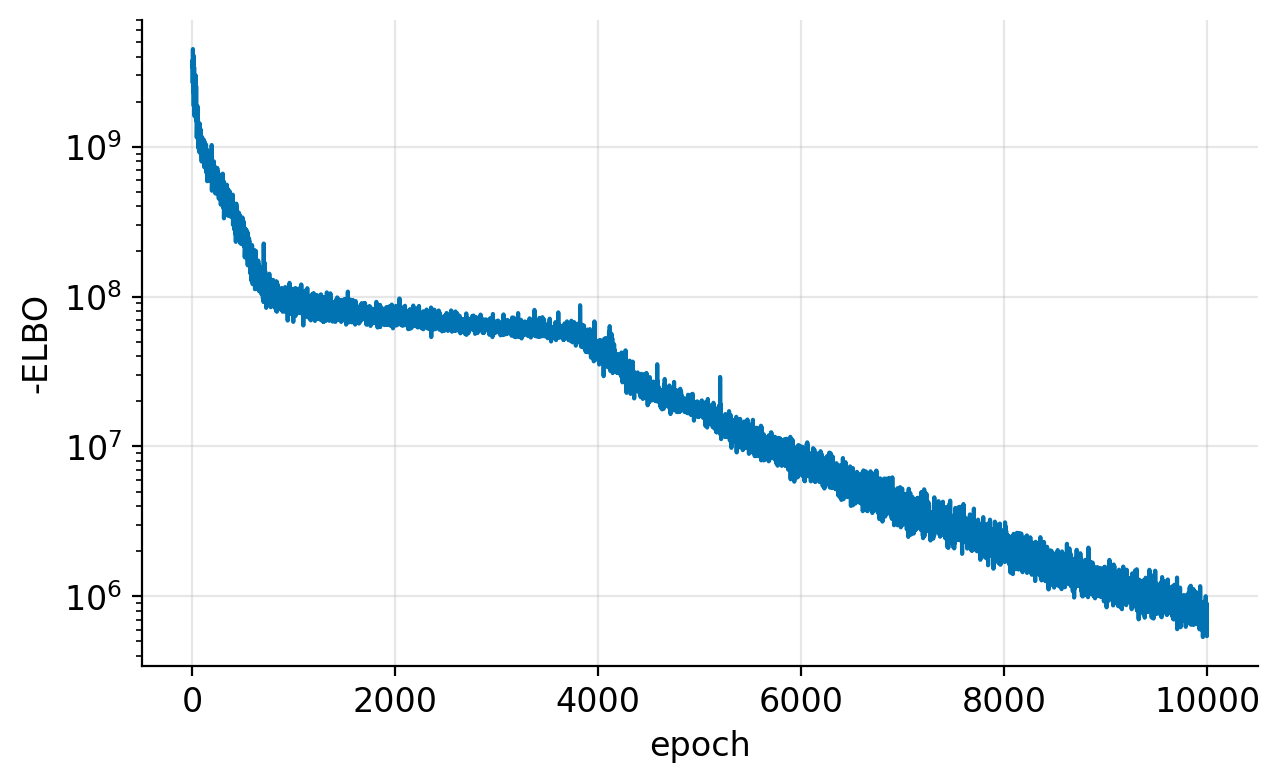

In [20]:
plt.plot(hist)
plt.yscale("log")
plt.grid(alpha=0.3)
plt.xlabel("epoch")
plt.ylabel("-ELBO")

## Eval

In [16]:
n_samples = 100

In [17]:
eps = jax.random.normal(key, (n_samples, n_params))
eps = jax.vmap(rfn)(eps)

theta = jax.tree.map(eval_params, eps, state_mu_final.params, state_rho_final.params)
jax.tree.map(jnp.shape, theta)

{'params': {'Dense_0': {'bias': (100, 20), 'kernel': (100, 1, 20)},
  'Dense_1': {'bias': (100, 20), 'kernel': (100, 20, 20)},
  'Dense_2': {'bias': (100, 20), 'kernel': (100, 20, 20)},
  'last_layer': {'bias': (100, 1), 'kernel': (100, 20, 1)}}}

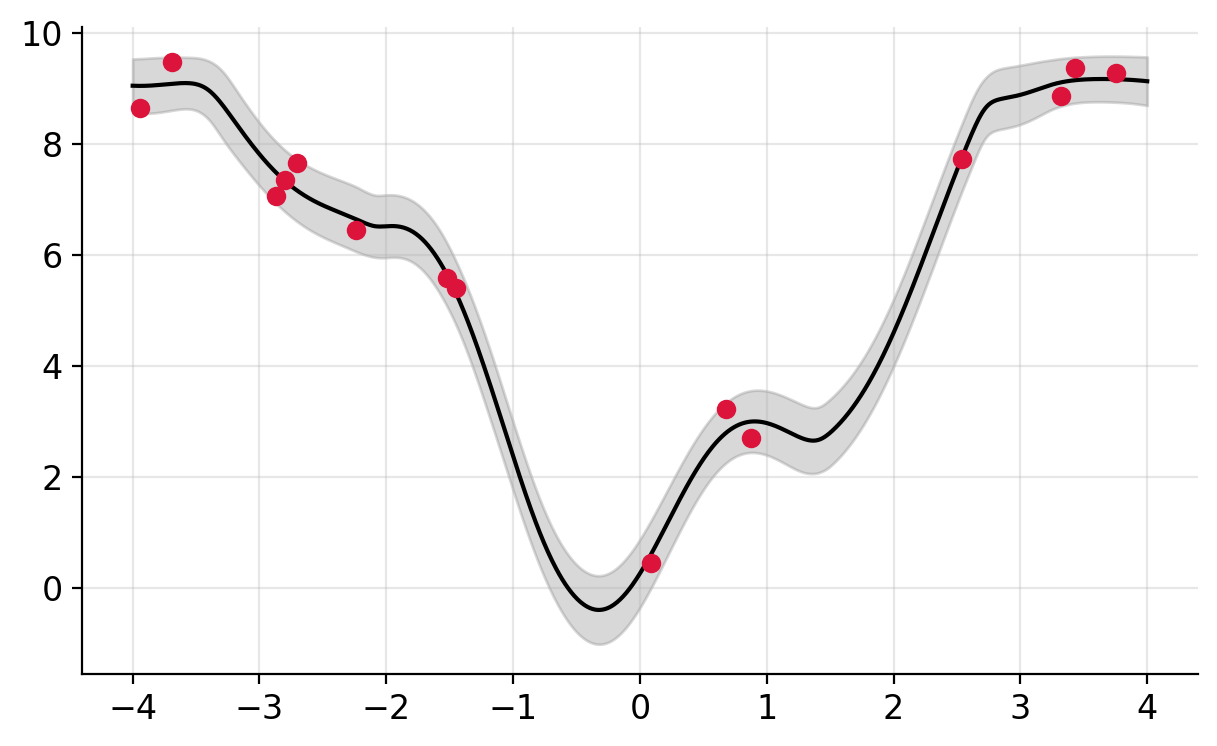

In [18]:
ysamples = jax.vmap(model.apply, in_axes=(0, None))(theta, xrange[:, None]).squeeze()

mid = ysamples.mean(axis=0)
lbound = mid - 2 * ysamples.std(axis=0)
ubound = mid + 2 * ysamples.std(axis=0)

plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.plot(xrange, mid, color="black")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
plt.grid(alpha=0.3)

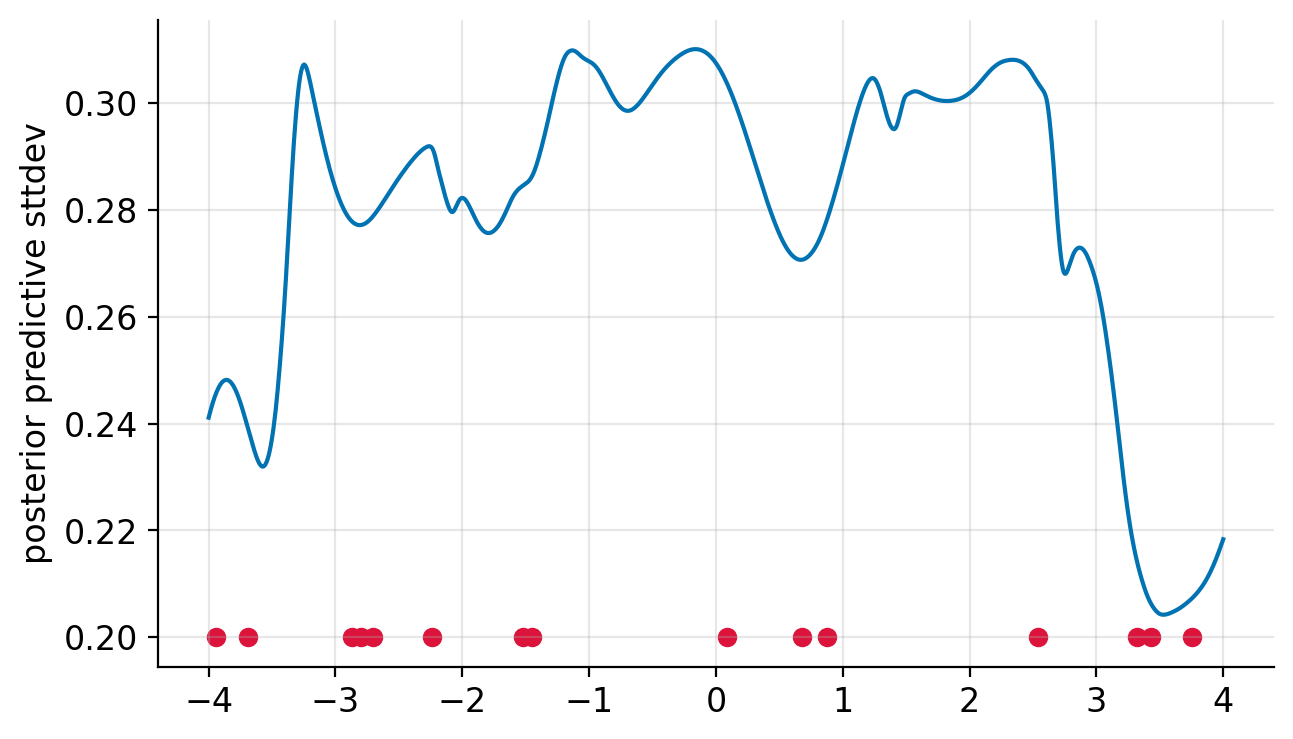

In [19]:
plt.plot(xrange, ysamples.std(axis=0))
plt.scatter(x_samples, jnp.ones_like(y_samples) * 0.2, c="crimson")
plt.ylabel("posterior predictive sttdev")
plt.grid(alpha=0.3)

## References

* [1] Jospin, L. V., Laga, H., Boussaid, F., Buntine, W., & Bennamoun, M. (2022). Hands-On Bayesian Neural Networks — a Tutorial for Deep Learning Users. IEEE Computational Intelligence Magazine, 17(2), 29–48. doi:10.1109/mci.2022.3155327

* [2] Blundell, C., Cornebise, J., Kavukcuoglu, K., & Wierstra, D. (2015). Weight Uncertainty in Neural Networks. doi:10.48550/ARXIV.1505.05424